<h1><center>Nordeus Assignment - A/B test analysis</center></h1>

#### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import ttest_ind
import scipy.stats as stats
import statsmodels.stats.api as sms

pd.set_option("display.max_columns", None)

#### Helper functions

In [2]:
def check_missing_values(df):
    # Check if columns have NaNs
    columns_with_nans = df.columns[df.isnull().any()]
    
    # Check if df has NaNs
    has_nans =len(columns_with_nans) > 0
    
    return has_nans, columns_with_nans


def plot_venn_diagram(set1, set2, set3, title, label_1, label_2):
    plt.figure(figsize=(10,5))

    # Make a Basic Venn
    v = venn3([set1, set2, set3], set_labels = ('A', 'B', ''))

    # Custom it
    v.get_patch_by_id('100').set_alpha(1.0)
    v.get_patch_by_id('001').set_color('white')
    # v.get_label_by_id('100').set_text('Unknown')
    v.get_label_by_id('A').set_text("A")
    c = venn3_circles(subsets=[set1, set2, set3], linestyle='dashed')
    c[2].set_ls('dotted')

    # # Add title and annotation
    plt.title(title)
    plt.annotate(label_1, xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-100),
    ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

    plt.annotate(label_1, xy=v.get_label_by_id('010').get_position() - np.array([0, 0.05]), xytext=(70, -100),
    ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

    plt.annotate(label_2, xy=v.get_label_by_id('011').get_position() - np.array([0.5, 0.05]), xytext=(70, -130),
    ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

    plt.annotate(label_2, xy=v.get_label_by_id('011').get_position() - np.array([0.07, 0.05]), xytext=(70, 130),
    ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

    # Show it
    plt.show()
    
def find_list_of_churners(df):
    churn_list = []
    for user in df.login_id.unique():
        tmp_df = df[df["login_id"]==user]
        if (tmp_df.date_id.max() - tmp_df.last_login_day.max()) >= 21:
            churn_list.append(user)
            
    return churn_list

#### Load data

In [3]:
user_history_df = pd.read_csv("data/user_history.csv")
notifications_df = pd.read_csv("data/notification_allowed.csv")

In [4]:
user_history_df.head()

,login_id,registration_date_id,registration_channel,registration_country,payer,dau,sessions_count,playtime,last_login_day,days_active_last_7_days,cohort_size,elo_rating,arena_level,gold,runes_stash_class1_tier1,runes_stash_class2_tier1,runes_stash_class3_tier1,runes_stash_tier2,spell_runes_stash,hero_dust,item_dust,gold_gained_total,gold_bought_total,gold_spent_total,runes_gained_total_class1_tier1,runes_gained_total_class2_tier1,runes_gained_total_class3_tier1,runes_gained_total_tier_2,spell_runes_gained_total,runes_spent_class1_tier1,runes_spent_class2_tier1,runes_spent_class3_tier1,runes_spent_total_tier2,spell_runes_spent_total,hero_dust_spent_total,hero_dust_gained_total,tokens,tokens_gained_total,enter_queue_count,battles_played,battles_won,battles_played_total,battles_won_total,heroes_unlocked,heroes_level,hero_shards,minion_upgrades,free_chests_opened_total,silver_chests_opened_total,golden_chests_opened_total,magical_chests_opened_total,victory_chests_opened_total,pvp_event_small_chest_small,pvp_event_small_chest_medium,pvp_event_small_chest_large,pvp_event_big_chest_small,pvp_event_big_chest_medium,pvp_event_big_chest_large,cards_gained_total,minion_cards_gained_common_total,minion_cards_gained_rare_total,minion_cards_gained_epic_total,minion_cards_gained_legendary_total,spell_cards_gained_common_total,spell_cards_gained_rare_total,spell_cards_gained_epic_total,spell_cards_gained_legendary_total,campaign_tickets,max_campaign_level,equipment_bonus,campaign_battles,campaign_battles_total,event_battles,event_battles_total,event_tokens,group_points,lives_spent,milestone_points,date_id
0,1,0,Organic,Canada,False,1,3,1351,0,1,1,0,0,271,1,4,3,1,2,5,10,171,0,0,9,12,7,1,2,8,8,4,0,0,0,5,90,90,4,4,4,4,4,1,1,3,5,2,0,0,0,0,0,0,0,0,0,0,8,5,2,0,0,0,1,0,0,2,1,0.0,5,5,0,0,15,0,0,0,0
1,2,0,Organic,Brazil,False,1,1,1046,0,1,1,0,0,202,2,2,3,1,1,0,10,102,0,0,2,16,3,1,1,0,14,0,0,0,0,0,90,90,4,4,4,4,4,1,1,2,3,0,0,0,0,0,0,0,0,0,0,0,5,3,1,0,0,0,1,0,0,1,0,0.0,2,2,0,0,15,0,0,0,0
2,3,0,Organic,Brazil,False,1,7,5854,0,1,1,140,1,402,12,4,3,3,23,0,210,352,0,50,46,25,41,3,23,34,21,38,0,0,0,0,130,130,18,17,15,17,15,1,1,4,18,2,1,0,0,2,0,0,0,0,0,0,17,13,2,1,0,0,1,0,0,2,3,0.0,8,8,0,0,40,0,0,0,0
3,4,0,Paid,France,False,1,1,772,0,1,1,0,0,198,3,2,3,0,20,0,10,98,0,0,3,2,3,0,20,0,0,0,0,0,0,0,130,130,3,3,3,3,3,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,5,3,1,0,0,0,1,0,0,2,0,0.0,1,1,0,0,40,0,0,0,0
4,5,0,Paid,United Kingdom,False,1,1,521,0,1,1,0,0,158,0,0,0,0,0,0,10,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,1,0,0.0,2,2,0,0,5,0,0,0,0


In [5]:
notifications_df.head()

,login_id,time,allowed_notifications,date_id
0,352,999,True,0
1,184,2780,True,0
2,162,2928,False,0
3,130,3689,True,0
4,124,4547,True,0


#### Quick data check & info

In [6]:
has_nans, columns_with_nans = check_missing_values(notifications_df)
print("Data has NaNs: {}, Columns with Nans: {}".format(has_nans, columns_with_nans))

# notifications_df.info()

Data has NaNs: False, Columns with Nans: Index([], dtype='object')


In [7]:
has_nans, columns_with_nans = check_missing_values(user_history_df)
print("Data has NaNs: {}, Columns with Nans: {}".format(has_nans, columns_with_nans))

# user_history_df.info()

Data has NaNs: False, Columns with Nans: Index([], dtype='object')


#### Data cleaning

##### Notifications data - cleaning

In [8]:
# Remove all records that are outside test period (two weeks)
n_users_before = notifications_df.shape[0]
notifications_df = notifications_df[notifications_df["date_id"]<=13]

# # Add test_group flag to make distinction between A and B test groups
# notifications_df['test_group'] = np.where(notifications_df['login_id'] % 2 == 0, "A", "B")

# # TODO: Remove this!
# notifications_df = notifications_df.groupby('test_group').apply(lambda x: x.sample(n=968)).reset_index(drop = True)
n_users_after = notifications_df.shape[0]

print("Number of users before: {} and after {} data cleaning.".format(n_users_before, n_users_after))

Number of users before: 3859 and after 3829 data cleaning.


##### User history data - cleaning

In [9]:
# Take only history data for users from A & B test groups

n_users_before = len(user_history_df["login_id"].unique())
user_history_df = user_history_df[user_history_df["login_id"].isin(notifications_df["login_id"].unique())]
n_users_after = len(user_history_df["login_id"].unique())

print("Number of users before: {} and after {} data cleaning.".format(n_users_before, n_users_after))

Number of users before: 4979 and after 3829 data cleaning.


<h2><center>Analyze Hit Rate (notification_allowed.csv)</center></h2>

In [10]:
# Add test_group flag to make distinction between A and B test groups
notifications_df['test_group'] = np.where(notifications_df['login_id'] % 2 == 0, "A", "B")

notifications_df.head()

,login_id,time,allowed_notifications,date_id,test_group
0,352,999,True,0,A
1,184,2780,True,0,A
2,162,2928,False,0,A
3,130,3689,True,0,A
4,124,4547,True,0,A


In [11]:
hit_rate_summary = notifications_df.pivot_table(values='allowed_notifications', index='test_group', aggfunc=np.sum)
hit_rate_summary['total_players'] = notifications_df.pivot_table(values='allowed_notifications', index='test_group', aggfunc=lambda x: len(x))
hit_rate_summary["hit_rate"] = hit_rate_summary["allowed_notifications"] / hit_rate_summary["total_players"]
hit_rate_summary

,allowed_notifications,total_players,hit_rate
test_group,,,
A,1434.0,2487,0.576598
B,845.0,1342,0.629657


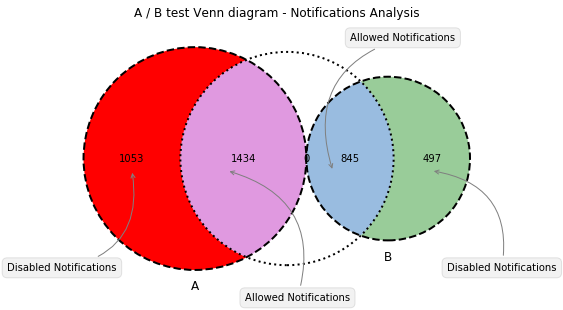

In [12]:
group_a = set(notifications_df[notifications_df["test_group"]=="A"]["login_id"])
group_b = set(notifications_df[notifications_df["test_group"]=="B"]["login_id"])
group_c = set(notifications_df[notifications_df["allowed_notifications"]==True]["login_id"])

plot_venn_diagram(group_a, 
                  group_b, 
                  group_c, 
                  "A / B test Venn diagram - Notifications Analysis", 
                  "Disabled Notifications", 
                  "Allowed Notifications")

#### Comments:
* Test group B has higher hit rate percentage than goup A.
* There is a missmatch in group size between A and B.

In [13]:
size_a = hit_rate_summary["total_players"].loc["A"]
size_b = hit_rate_summary["total_players"].loc["B"]

success_a = int(hit_rate_summary["allowed_notifications"].loc["A"])
success_b = int(hit_rate_summary["allowed_notifications"].loc["B"])

success_rate_a = hit_rate_summary["hit_rate"].loc["A"]
success_rate_b = hit_rate_summary["hit_rate"].loc["B"]

difference = success_rate_b - success_rate_a
lift = (success_rate_b - success_rate_a) / success_rate_a

In [14]:
print("Group A - Hit rate: {:.2%}".format(success_rate_a))
print("Group B - Hit rate: {:.2%}".format(success_rate_b))
print("Difference: {:.2%}".format(difference))
print('Lift: '+'{:.2%}'.format(lift))

Group A - Hit rate: 57.66%
Group B - Hit rate: 62.97%
Difference: 5.31%
Lift: 9.20%


### Test Hypothesis and Check Statistical Significance

##### Test Hypothesis

$$
H_0 : p_A = p_B 
$$
$$
H_1 : p_a \neq p_B
$$

* H0: Hit rates of A and B test sets are equal.
* H1: Hit rates of A and B test sets are different.

In [15]:
# Success proportions
prop_a = success_a / size_a
prop_b = success_b / size_b

# Calculate pool probability (Since we don't know probability of population, use estimate)
prop_pooled = (success_a + success_b) / (size_a + size_b)

# Calculate variance
# Var(pa - pb) = Var(pa) + Var(pb)
# Binomial distribution -> Var(pa) = pa(1-pa)/na
var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)

# Calculate z-score
zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)

# This is two-sided test so multiply by 2
pvalue = one_side * 2

if pvalue<.05:
    print("We have strong evidence to reject H0 hypothesis.")
else:
    print("We don't have strong evidence to reject H0 hypothesis.")
    
    
print("Z-score: {:.5f} p-value: {:.5f}".format(zscore, pvalue))

We have strong evidence to reject H0 hypothesis.
Z-score: 3.19137 p-value: 0.00142


In [16]:
# Same thing but in two lines using scipy's Welch test

# ttest = ttest_ind(notifications_df[notifications_df["test_group"]=="A"]["allowed_notifications"].values,
#                   notifications_df[notifications_df["test_group"]=="B"]["allowed_notifications"].values)
# print(ttest)

#### Find confidence interval

In [17]:
# We proved that pa=pb is not true!

# Calculate 95% confidence interval for pa - pb
significance = 0.05

# Calculate variance (We rejected H0 so we can't use pool probability)
var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
se = np.sqrt(var)
    
# z critical value
confidence = 1 - significance
z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

# Calculate confidence interval
# point-estimtate +- z * standard-error
prop_diff = prop_b - prop_a
margin_error = z * se
lower_bound = prop_diff - margin_error
upper_bound = prop_diff + margin_error
confint = [lower_bound, upper_bound]

print('Estimate difference:', prop_diff)
print("Confidence interval [{:.5f}  {:.5f}]".format(lower_bound, upper_bound))

Estimate difference: 0.0530589167995
Confidence interval [0.02074  0.08538]


#### Check sample size

In [18]:
# Check if we had enough samples to draw a valid conclusion

# Significance level is 5% meanineg that there is a 5% chance of a false positive. (Rejecting Ho when it is actually true)
siginificance = 0.05

# Statistical power 80% meaning that (1-0.8) is the probability to make type 2 error (False negative - Accept Ho when it is false])
power = 0.8

# Set baseline proportion
prop1 = success_rate_a 

# Set minimum difference
min_diff = difference

# Set success proportion
prop2 = prop1 + min_diff

# Calculate effect size
effect_size = sms.proportion_effectsize(prop1, prop2)
sample_size = sms.NormalIndPower().solve_power(effect_size, power = power, alpha = significance, ratio = 1)

print('Sample size required per group:', sample_size)

Sample size required per group: 1333.2045750466027


<h2><center>Analyze Player Retention (user_history.csv)</center></h2>

In [19]:
# Find churners from user_history_df
churn_list = find_list_of_churners(user_history_df)

# Add retention flag to notifications_df
notifications_df["retention"] = np.where(notifications_df['login_id'].isin(churn_list), False, True)
notifications_df.head()

,login_id,time,allowed_notifications,date_id,test_group,retention
0,352,999,True,0,A,False
1,184,2780,True,0,A,False
2,162,2928,False,0,A,False
3,130,3689,True,0,A,False
4,124,4547,True,0,A,True


In [20]:
retention_summary = notifications_df.pivot_table(values='retention', index='test_group', aggfunc=np.sum)
retention_summary['total_players'] = notifications_df.pivot_table(values='retention', index='test_group', aggfunc=lambda x: len(x))
retention_summary["retention_rate"] = retention_summary["retention"] / retention_summary["total_players"]
retention_summary

,retention,total_players,retention_rate
test_group,,,
A,821.0,2487,0.330117
B,855.0,1342,0.637109


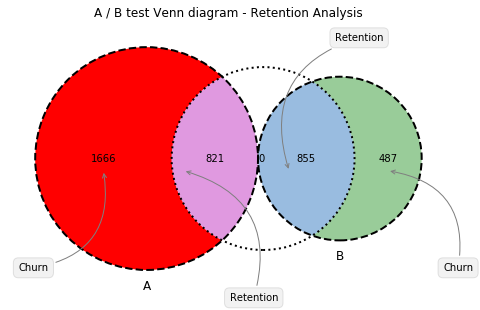

In [21]:
group_a = set(notifications_df[notifications_df["test_group"]=="A"]["login_id"])
group_b = set(notifications_df[notifications_df["test_group"]=="B"]["login_id"])
group_d = set(notifications_df[notifications_df["retention"]==True]["login_id"])

plot_venn_diagram(group_a, 
                  group_b, 
                  group_d, 
                  "A / B test Venn diagram - Retention Analysis", 
                  "Churn", 
                  "Retention")

In [22]:
size_a = retention_summary["total_players"].loc["A"]
size_b = retention_summary["total_players"].loc["B"]

retention_a = int(retention_summary["retention"].loc["A"])
retention_b = int(retention_summary["retention"].loc["B"])

retention_rate_a = retention_summary["retention_rate"].loc["A"]
retention_rate_b = retention_summary["retention_rate"].loc["B"]

difference = retention_rate_b - retention_rate_a
lift = (retention_rate_b - retention_rate_a) / retention_rate_a

In [23]:
print("Group A - Retention rate: {:.2%}".format(retention_rate_a))
print("Group B - Retention rate: {:.2%}".format(retention_rate_b))
print("Difference in Retention rate: {:.2%}".format(difference))
print('Lift: '+'{:.2%}'.format(lift))

Group A - Retention rate: 33.01%
Group B - Retention rate: 63.71%
Difference in Retention rate: 30.70%
Lift: 93.00%


### Test Null Hypothesis and Check Statistical Significance

##### Test Hypothesis

$$
H_0 : p_A = p_B 
$$
$$
H_1 : p_a \neq p_B
$$

* H0: Retention rates of A and B test sets are equal.
* H1: Retention rates of A and B test sets are different.

In [24]:
# Success proportions
prop_a = retention_a / size_a
prop_b = retention_b / size_b

# Calculate pool probability (Since we don't know probability of population, use estimate)
prop_pooled = (retention_a + retention_b) / (size_a + size_b)

# Calculate variance
# Var(pa - pb) = Var(pa) + Var(pb)
# Binomial distribution -> Var(pa) = pa(1-pa)/na
var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)

# Calculate z-score
zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)

# This is two-sided test so multiply by 2
pvalue = one_side * 2

if pvalue<.05:
    print("We have strong evidence to reject H0 hypothesis.")
else:
    print("We don't have strong evidence to reject H0 hypothesis.")
    
    
print("Z-score: {:.5f} p-value: {:.5f}".format(zscore, pvalue))

We have strong evidence to reject H0 hypothesis.
Z-score: 18.26944 p-value: 0.00000


In [25]:
# Same thing but in one two lines using scipy's Welch test

# ttest = ttest_ind(notifications_df[notifications_df["test_group"]=="A"]["retention"].values,
#                   notifications_df[notifications_df["test_group"]=="B"]["retention"].values)
# print(ttest)

#### Find confidence interval

In [26]:
# We proved that pa=pb is not true!

# Calculate 95% confidence interval for pa - pb
significance = 0.05

# Calculate variance (We rejected H0 so we can't use pool probability)
var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
se = np.sqrt(var)
    
# z critical value
confidence = 1 - significance
z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

# Calculate confidence interval
# point-estimtate +- z * standard-error
prop_diff = prop_b - prop_a
margin_error = z * se
lower_bound = prop_diff - margin_error
upper_bound = prop_diff + margin_error
confint = [lower_bound, upper_bound]

print('Estimate difference:', prop_diff)
print("Confidence interval [{:.5f}  {:.5f}]".format(lower_bound, upper_bound))

Estimate difference: 0.306992186493
Confidence interval [0.27532  0.33867]


#### Check sample size

In [27]:
# Check if we had enough samples to draw a valid conclusion

# Significance level is 5% meanineg that there is a 5% chance of a false positive. (Rejecting Ho when it is actually true)
siginificance = 0.05

# Statistical power 80% meaning that (1-0.8) is the probability to make type 2 error (False negative - Accept Ho when it is false])
power = 0.8

# Set baseline proportion
prop1 = retention_rate_a 

# Set minimum difference
min_diff = difference

# Set success proportion
prop2 = prop1 + min_diff

# Calculate effect size
effect_size = sms.proportion_effectsize(prop1, prop2)
sample_size = sms.NormalIndPower().solve_power(effect_size, power = power, alpha = significance, ratio = 1)

print('Sample size required per group:', sample_size)

Sample size required per group: 40.25764074296313


<h2><center>Conclusion</center></h2>

Statistical anlysis of A/B test results proves that:
* it is better to ask users to allow push notifications after the tutorial, and,
* hit rate will be higher (by 5.31%),
* retention rate will be higher (by 30.70%),
* obtained results are statistically significant,
* A/B testing sample size ensures trustworthy results.